# Session Length

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi

In [2]:
# import data, with all columns with string data type, for now
data = pd.read_csv('data1.csv')
# change data type to time stamp in 'event_timestamp'
data['event_timestamp'] = data['event_timestamp'].astype('datetime64[s]')
data.head()

,event_id,event_timestamp,page_title,organization_id,user_id,month,week,day,day_of_week
0,ajs-51c205dff7f3f3541943fc69498875cc,2020-01-02 11:47:43,Welcome,18f6d076-394c-41d2-8ec6-e8b870535798,27f92d62-dbaa-4512-8b31-5ef541716695,1,1,2,Thursday
1,ajs-e49668e966f11460a35c70e9cab9edcd,2020-01-02 11:48:07,Welcome,18f6d076-394c-41d2-8ec6-e8b870535798,27f92d62-dbaa-4512-8b31-5ef541716695,1,1,2,Thursday
2,ajs-0aedceadad5d3d4f8ec2367bd4230c39,2020-01-02 11:48:16,Job position,18f6d076-394c-41d2-8ec6-e8b870535798,27f92d62-dbaa-4512-8b31-5ef541716695,1,1,2,Thursday
3,ajs-90802aefaa8f58920c8dfcce19304fad,2020-01-05 16:30:59,Job position,18f6d076-394c-41d2-8ec6-e8b870535798,27f92d62-dbaa-4512-8b31-5ef541716695,1,1,5,Sunday
4,ajs-8354ae15e8bbe83e06efc759737c0932,2020-01-05 16:31:04,All job positions,18f6d076-394c-41d2-8ec6-e8b870535798,27f92d62-dbaa-4512-8b31-5ef541716695,1,1,5,Sunday


In [3]:
def sessions(df, user, day):
    # create a subframe for that user and day
    cols = ['event_id', 'event_timestamp', 'page_title','user_id','day']
    user_day = df[(df['user_id'] == user) & (data['day'] == day)][cols].reset_index()
    
    # sort by event_timestamp
    user_day = user_day.sort_values('event_timestamp')
    
    # create a delta column, between a row and the next one
    user_day['delta'] = (user_day['event_timestamp']-user_day['event_timestamp'].shift())
    user_day['delta in sec'] = user_day['delta'].apply(lambda x: x/np.timedelta64(1, 's')).fillna(0).astype('int64')
    
    # create a start column, when delta == 0 or delta > 2 hours
    between_sessions = 7200 #2 hours in second
    condition = (user_day['delta in sec'] == 0)| (user_day['delta in sec'] > between_sessions)
    user_day['start'] = np.where(condition, 1, 0)
    
    # get the start indexes
    index_start = user_day.index[user_day['start'] == 1].tolist()

    # create the end index, on the row previous at the start one, and at the end
    index_end = [i - 1 for i in index_start]
    index_end = [i for i in index_end if i > 0]
    # and add the last index on the data set
    index_end.append(user_day.index[-1])
    
    # locate 1s on the positions
    for i in index_end:
        user_day.loc[i, 'end'] = 1
        
    # fill the rest with 0
    user_day['end'] = user_day['end'].fillna(0)
    
    # select starting points and end points
    starts = user_day[user_day['start'] == 1]['event_timestamp'].values
    ends = user_day[user_day['end'] == 1]['event_timestamp'].values
    
    return starts, ends

In [4]:
unique_users = data['user_id'].unique()

In [5]:
res = {}
for user in unique_users:
    # select the days they are active
    days = data[data['user_id'] == user]['day'].unique()
    for day in days:
        starts = sessions(data, user, day)[0]
        ends = sessions(data, user, day)[1]
        for i in range(len(ends)):
            diff = ends[i] - starts[i]
            diff = diff.astype('timedelta64[m]')
            diff = diff.astype('int64')
            res[user+'----'+str(i)] = diff     

In [6]:
sessions_df = pd.DataFrame(res.items())
sessions_df.to_csv('sessions.csv', index=False)

In [7]:
sessions_df.columns = ['user_id', 'session_length']

In [8]:
sessions_df.head()

,user_id,session_length
0,27f92d62-dbaa-4512-8b31-5ef541716695----0,0
1,27f92d62-dbaa-4512-8b31-5ef541716695----1,0
2,0c5827be-129c-4716-8a97-0ca0a23e2545----0,1
3,0c5827be-129c-4716-8a97-0ca0a23e2545----1,0
4,0c5827be-129c-4716-8a97-0ca0a23e2545----2,0


In [9]:
value_counts = pd.DataFrame(sessions_df['session_length'].value_counts()).reset_index()
value_counts.columns = ['session_length', 'frequency']
value_counts = value_counts.sort_values('session_length')
value_counts.head(10)

,session_length,frequency
0,0,537
1,1,64
2,2,24
3,3,24
4,4,21
6,5,13
8,6,12
13,7,10
11,8,11
12,9,10


In [10]:
len(value_counts[value_counts['session_length'] > 240]['frequency'].values)

13

In [11]:
# lets look into the sessions > 0 min and < 240 (4 hrs)
sessions_more_zero = sessions_df[(sessions_df['session_length'] > 0) & (sessions_df['session_length'] < 240)]
sessions_more_zero.head()

,user_id,session_length
2,0c5827be-129c-4716-8a97-0ca0a23e2545----0,1
5,0c5827be-129c-4716-8a97-0ca0a23e2545----3,40
8,f2b0fb3c-5663-47c0-a794-4b217f2bf8b8----2,1
9,4a6ab0ea-4d17-43e0-a273-c5705985ccd6----0,21
10,4a6ab0ea-4d17-43e0-a273-c5705985ccd6----1,9


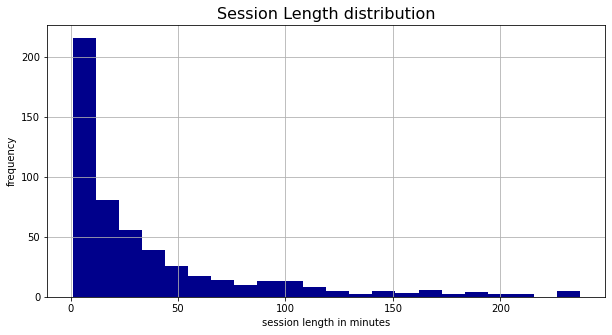

counts [216.  81.  56.  39.  26.  17.  14.  10.  13.  13.   8.   5.   2.   5.
   3.   6.   2.   4.   2.   2.   0.   5.]

bins [  1.          11.72727273  22.45454545  33.18181818  43.90909091
  54.63636364  65.36363636  76.09090909  86.81818182  97.54545455
 108.27272727 119.         129.72727273 140.45454545 151.18181818
 161.90909091 172.63636364 183.36363636 194.09090909 204.81818182
 215.54545455 226.27272727 237.        ]

n bins 23


In [12]:
x = sessions_more_zero['session_length']
plt.figure(figsize=(10,5))
counts, bins, bars = plt.hist(x, bins=22, color='darkblue')
plt.grid(True)
plt.title('Session Length distribution', fontsize = 16)
plt.ylabel('frequency')
plt.xlabel('session length in minutes')
plt.savefig('figures/3/1_session_length', bbox_inches='tight')
plt.show()
print('counts',  counts)
print('')
print('bins', bins)
print('')
print('n bins', len(bins))

In [13]:
dfi.export(round(sessions_more_zero.describe().transpose()), 'tables/table3.png')
round(sessions_more_zero.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
session_length,529.0,36.0,47.0,1.0,4.0,18.0,45.0,237.0
